<a href="https://colab.research.google.com/github/jpvega-github/eliza/blob/master/Copy_of_Final_NVDIA_Prediction_High_Stock_Price_Next_1_Day_170Epoch5Batch_0_00Dropout.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NVIDIA Stock Highest Price Prediction for the next 1 day
* Purpose
  * Code for predicting the next 1 day of Nvidia's stock price
* Model
  * The model is trained on data from `2016-10-03` to `insert`
  * The model is trained and tested on `High` stock prices since we are trying to ensure our covered calls are safe from being executed
  * The model is tested on data from `insert` to `insert`
  * The model is then tested to see how well it performs on the next 1 day of unknown stock price for `given date`
* The model is fit as follows:

    `model.fit(features, labels, epochs = 170, batch_size = 5, verbose = 1)`

* Model build is as follows:
```
model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(units = 50, return_sequences = True, input_shape = (features.shape[1], 1)),
    #tf.keras.layers.Dropout(0.01),
    #tf.keras.layers.LSTM(units = 50, return_sequences = True),
    #tf.keras.layers.Dropout(0.01),
    tf.keras.layers.LSTM(units = 50, return_sequences = True),
    #tf.keras.layers.Dropout(0.01),
    tf.keras.layers.LSTM(units = 50),
    #tf.keras.layers.Dropout(0.01),
    tf.keras.layers.Dense(units = 1)
])
```

###**Let’s make this concrete with a small example**

Assume you have a dataset with 200 samples (rows of data) (FYI: my dataset has 202 samples) and you choose a batch size of 5 and 1,000 epochs.

* **This means that the dataset will be divided into 40 batches (`200/5 = 40`), each with five samples. The model weights will be updated after each batch of five samples.**

* **This also means that ONE EPOCH...** will involve 40 batches or 40 updates to the model.

**With 1,000 epochs,..** the model will be exposed to or pass through the whole dataset 1,000 times. That is a total of 40,000 batches during the entire training process.

See: https://machinelearningmastery.com/difference-between-a-batch-and-an-epoch/

# Intro to LSTMs

We will predict stock prices with Long short-term memory (LSTM).

LSTMs are very powerful in sequence prediction problems. They can store past information.

LSTM models predict time series data. Stock market data is a great choice for this because it's quite regular and widely available via the Internet.


In [34]:
# Let's mount our google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [35]:
# Let's install tensorflow
# TensorFlow is a free and open-source software library for machine learning. 
# It can be used across a range of tasks but has a particular focus on training and inference of deep neural networks.
# Tensorflow is a symbolic math library based on dataflow and differentiable programming

!pip install tensorflow

In [36]:
# matplotlib-venn: The package provides four main functions: venn2, venn2_circles, venn3 and venn3_circles.
# The functions venn2 and venn2_circles accept as their only required argument a 3-element list (Ab, aB, AB) of subset sizes, e.g.:
# venn2(subsets = (3, 2, 1))

# Let's install this package
!pip install matplotlib-venn

In [37]:
!apt-get -qq install -y libfluidsynth1

In [38]:
# libarchive-dev: a multi-format archive and compression library (development files).
# The libarchive library provides a flexible interface for reading and writing archives 
# in various formats such as tar and cpio. 
# libarchive also supports reading and writing archives compressed using various 
# compression filters such as gzip and bzip2. 
# The library is inherently stream-oriented; 
# readers serially iterate through the archive, writers serially add things to the archive.
#  Archive formats supported are:
#   * tar (read and write, including GNU extensions)
#   * pax (read and write, including GNU and star extensions)
#   * cpio (read and write, including odc and newc variants)
#   * iso9660 (read and write, including Joliet and Rockridge extensions, with some limitations)
#   * zip (read only, with some limitations, uses zlib)
!apt-get -qq install -y libarchive-dev && pip install -U libarchive
import libarchive

In [39]:
# pandas-datareader: Up-to-date remote data access for pandas. Works for multiple versions of pandas.
!pip install pandas-datareader

In [40]:
# Graphviz is open source graph visualization software. 
# Graph visualization is a way of representing structural information as 
# diagrams of abstract graphs and networks. It has important applications 
# in networking, bioinformatics, software engineering, database and web design, 
# machine learning, and in visual interfaces for other technical domains.
# =====================================================================================
# pydot: is an interface to Graphviz
# It can parse and dump into the DOT language used by GraphViz, is written in pure Python,
# and networkx can convert its graphs to pydot.

!apt-get -qq install -y graphviz && pip install pydot
import pydot

In [41]:
# Let's install yfinance
# yfinance is a library, see https://pypi.org/project/yfinance/ and https://aroussi.com/post/python-yahoo-finance
# yfinance offers a reliable, threaded, and Pythonic way to download historical market data from Yahoo! finance.
# The Ticker module, which allows you to access ticker data in a more Pythonic way.

!pip install yfinance

In [42]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas_datareader import data

In [43]:
# Let's import yfinance
import yfinance as yf

# Let's get our training data

Here, I use pandas-datareader to get the historical stock prices from Yahoo! finance. I only get the historical data until the date I want to use to train my model.

I will train my model using Nvidia's historical stock data between (2016-10-03) to (whatever date)

In [44]:
# Let's get Nvidia's stock price history
nvidia_stock_prices = yf.Ticker('Nvda')

# nvidia started trading on '1999-01-23'.
# seems like getting rid of the start numbers where it was flat was good decision; 
start_date = '2016-10-03' # keeper date 
end_date = '2021-10-16'

# stock_data = data.get_data_yahoo(tickers, start_date, end_date)
stock_data = nvidia_stock_prices.history(start= start_date, end=end_date)

In [12]:
stock_data

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2016-10-03,16.883948,17.127894,16.837131,16.866699,24259600,0.0,0.0
2016-10-04,16.891345,17.174714,16.704073,16.829742,28162400,0.0,0.0
2016-10-05,16.972655,17.145142,16.760743,16.812490,30544000,0.0,0.0
2016-10-06,16.610432,16.713923,16.327061,16.593182,36021200,0.0,0.0
2016-10-07,16.704068,16.748421,16.425626,16.472443,28626000,0.0,0.0
...,...,...,...,...,...,...,...
2021-10-11,205.750000,210.630005,205.110001,206.949997,16338800,0.0,0.0
2021-10-12,208.279999,210.570007,205.279999,206.710007,16213400,0.0,0.0
2021-10-13,209.179993,209.899994,207.130005,209.389999,18065200,0.0,0.0


In [13]:
# Let's see the tail of our data
stock_data.tail()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2021-10-11,205.750000,210.630005,205.110001,206.949997,16338800,0.0,0.0
2021-10-12,208.279999,210.570007,205.279999,206.710007,16213400,0.0,0.0
2021-10-13,209.179993,209.899994,207.130005,209.389999,18065200,0.0,0.0
2021-10-14,212.880005,217.550003,211.220001,217.460007,24358900,0.0,0.0
2021-10-15,218.100006,219.309998,216.619995,218.619995,22679500,0.0,0.0


In [ ]:
# Let's see Nvidia's Option Chain
#nvidia_stock_prices.option_chain()

In [45]:
# Let's see how many records we have
stock_data_len = stock_data['High'].count()
print(stock_data_len)

1269


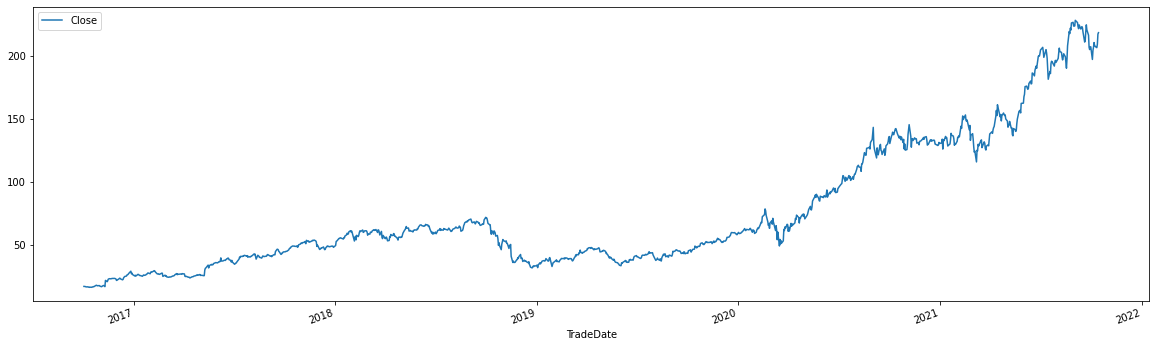

In [ ]:
# Let's plot our training data

# Creating a column as date
stock_data['TradeDate']=stock_data.index
 
# Plotting the stock prices
%matplotlib inline
stock_data.plot(x='TradeDate', y='Close', kind='line', figsize=(20,6), rot=20)

# Intro to iloc[ ]
see: https://www.shanelynn.ie/pandas-iloc-loc-select-rows-and-columns-dataframe/

#### **Multiple row and column selections using iloc and DataFrame**
```
data.iloc[0:5] # first five rows of dataframe
data.iloc[:, 0:2] # first two columns of data frame with all rows
data.iloc[[0,3,6,24], [0,5,6]] # 1st, 4th, 7th, 25th row + 1st 6th 7th columns.
data.iloc[0:5, 5:8] # first 5 rows and 5th, 6th, 7th columns of data frame
```
 
#### **Single selections using iloc and DataFrame**
#### **Rows:**
```
data.iloc[0] # first row of data frame - Note a Series data type output.
data.iloc[1] # second row of data frame 
data.iloc[-1] # last row of data frame 
```
#### **Columns:**
```
data.iloc[:,0] # first column of data frame 
data.iloc[:,1] # second column of data frame 
data.iloc[:,-1] # last column of data frame
```

# Let's get the high prices

In [46]:
# Let's get the high prices only which is in column 1
# [:, 1:2] === means we get all rows, column 1 inclusive, column 2 exclusive 
# we are taking a slice of the columns and all rows.
# we take all rows and the first column which is our high price
# note: column 0 = open price
# note: column 1 = high price
high_prices = stock_data.iloc[:, 1:2].values

# Let's print our high prices
print(high_prices)

[[ 17.12789216]
 [ 17.17470394]
 [ 17.1451462 ]
 ...
 [209.8999939 ]
 [217.55000305]
 [219.30999756]]


In [ ]:
# Use this instead if you want to train the model on closing prices instead of the high price
#close_prices = stock_data.iloc[:, 3:4].values
#print(close_prices)



# Handling missing prices on weekdays that are Holidays (non-trading days)
There will be some weekdays that may occur on public holidays, so they will be non-trading days, thus, no price will be available. 

I will handle this occurance by filling the missing prices with the latest available prices.

Below are some example for frequency parameter:
```
Alias Description

B business day frequency

C custom business day frequency

D calendar day frequency

W weekly frequency

M month end frequency

```
##### See https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#timeseries-offset-aliases

In [47]:
all_bussinessdays = pd.date_range(start=start_date, end=end_date, freq='B')
print(all_bussinessdays)

DatetimeIndex(['2016-10-03', '2016-10-04', '2016-10-05', '2016-10-06',
               '2016-10-07', '2016-10-10', '2016-10-11', '2016-10-12',
               '2016-10-13', '2016-10-14',
               ...
               '2021-10-04', '2021-10-05', '2021-10-06', '2021-10-07',
               '2021-10-08', '2021-10-11', '2021-10-12', '2021-10-13',
               '2021-10-14', '2021-10-15'],
              dtype='datetime64[ns]', length=1315, freq='B')


In [48]:
# Let's reindex
# reindex(): Conform Series/DataFrame to new index with optional filling logic.
# filling logic used is ffill: propagates last valid observation forward to next valid
high_prices = stock_data.reindex(all_bussinessdays)
high_prices = stock_data.fillna(method='ffill')

In [ ]:
# use this for closing prices instead of high price
#close_prices = stock_data.reindex(all_bussinessdays)
#close_prices = stock_data.fillna(method='ffill')

# Let's store the 'high price' as training_set

Pre-Process the data = Feature scaling

We need to preprocess the data to prepare it for the LSTM model.

In [49]:
# I'm ready to store the 'high price' in an array called 'training_set' which I will use to train my model
training_set = high_prices.iloc[:, 1:2].values

In [17]:
# Let's print the training set
training_set

array([[ 17.1278941 ],
       [ 17.17470588],
       [ 17.14514036],
       ...,
       [209.8999939 ],
       [217.55000305],
       [219.30999756]])

In [ ]:
# use this for closing prices instead of high price
#training_set = close_prices.iloc[:, 3:4].values

# Let's now normalize our training data

Normalize data:

* Most of the times data is noisy. 
* Data comes in mixed scale and range. 
* Normalization helps to change the range and scale of data thereby bring uniformity to data.

Purpose of Normalization

* a key component in Data science for data pre-processing. 
* Most of the times data from multiple sources will be merged before the start of analysis. 
* example: 
  * Data has 'baggage' as one feature. 
  * The values can be either be in lbs or kgs (units of measurement). 
  * It is important to bring to the same scale before considering this feature for analysis otherwise it will end up giving in wrong signals.
  * Normalization helps in bringing to the same scale.

see: https://medium.com/transparent-deep-learning/normalization-in-machine-learning-and-deep-learning-56eb33eb0165


# Here is how we Normalized our data
#####**MinMaxScaler(feature_range = (0, 1))**
```
Syntax: def __init__(feature_range=(0, 1), copy=True)

Transform features by scaling each feature to a given range.
```
This estimator scales and translates each feature individually such
that it is in the given range on the training set, e.g. between
zero and one.

*The transformation is given by:*

`
X_std = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))
X_scaled = X_std * (max - min) + min
where min, max = feature_range.
`

*The transformation is calculated as:*

`
X_scaled = scale * X + min - X.min(axis=0) * scale
where scale = (max - min) / (X.max(axis=0) - X.min(axis=0))
`

This transformation is often used as an alternative to zero mean.


##### **training_set_scaled = sc.fit_transform(training_set)**

```
Syntax: def fit_transform(X, y=None, **fit_params)

Fit to data, then transform it.
```

Fits transformer to X and y with optional parameters fit_params
and returns a transformed version of X.

# **Importance of Data Scaling**
see: https://machinelearningmastery.com/how-to-transform-target-variables-for-regression-with-scikit-learn/

see: https://machinelearningmastery.com/standardscaler-and-minmaxscaler-transforms-in-python/

It is common to have data where the scale of values differs from variable to variable.

For example, one variable may be in feet, another in meters, and so on.

Some machine learning algorithms perform much better if all of the variables are scaled to the same range, such as scaling all variables to values between 0 and 1, called **normalization**.

The two most popular techniques for scaling numerical data prior to modeling are **normalization** and **standardization**. 
* Normalization scales each input variable separately to the range 0-1, which is the range for floating-point values where we have the most precision. 
* Standardization scales each input variable separately by subtracting the mean (called centering) and dividing by the standard deviation to shift the distribution to have a mean of zero and a standard deviation of one.

Scaling input and output variables is a critical step in using neural network models.

**Data Normalization**

Normalization is a rescaling of the data from the original range so that all values are within the new range of 0 and 1.

Normalization requires that you know or are able to accurately estimate the minimum and maximum observable values. You may be able to estimate these values from your available data.

A value is normalized as follows:

`y = (x – min) / (max – min)`

* Where the minimum and maximum values pertain to the value x being normalized.

* For example, for a dataset, we could guesstimate the min and max observable values as 30 and -10. We can then normalize any value, like 18.8, as follows:
```
y = (x – min) / (max – min)
y = (18.8 – (-10)) / (30 – (-10))
y = 28.8 / 40
y = 0.72
```

You can normalize your dataset using the **scikit-learn object MinMaxScaler**.

* **Fit the scaler using available training data**. For normalization, this means the training data will be used to estimate the minimum and maximum observable values. This is done by calling the fit() function.
* **Apply the scale to training data**. This means you can use the normalized data to train your model. This is done by calling the transform() function.
* **Apply the scale to data going forward**. This means you can prepare new data in the future on which you want to make predictions.

In [50]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)
print(training_set_scaled.shape)

(1269, 1)


In [51]:
# For review, let's see the original training set
training_set

array([[ 17.12789216],
       [ 17.17470394],
       [ 17.1451462 ],
       ...,
       [209.8999939 ],
       [217.55000305],
       [219.30999756]])

In [21]:
# Let's see the training set after tranformation to a range between 0-1
training_set_scaled

array([[0.00426837],
       [0.00448698],
       [0.00434891],
       ...,
       [0.90433383],
       [0.94005222],
       [0.94826975]])

In [ ]:
# Let's see the length of the training set post-scaling
len(training_set_scaled)

1269

In [ ]:
# Let's see the length of the stock data (pre-scaled)
# notice, it matches the scaled training set
len(stock_data)

1269

# Creating Data with Timesteps

**LSTMs** expect the data in a specific format, usually a 3D tensor. 

* I start by creating data with 60 days and 
* converting it into an array using NumPy. 
* then, I convert the data into a 3D array with
  * feature_set samples, 
  * 60 days and 
  * 1 feature at each step

In [52]:
# We will make our training set into groups of 60 and we will call the 'high prices' features(=inputs)
features = [] # this is our inputs(= true high prices = training data)
labels = [] # this is our outputs(= predicted high prices)

for i in range(13, len(stock_data)):
    features.append(training_set_scaled[i-13:i, 0])
    labels.append(training_set_scaled[i, 0])
    

# Note: this was recommend instead of the above code
# https://thinkingneuron.com/predicting-stock-prices-using-deep-learning-lstm-model-in-python/
# I found this to reduce my accuracy, but I keep it in case I find a use for it
#FutureTimeSteps = 5 
#for i in range(60, stock_data_len-FutureTimeSteps, 1):
#    features.append(training_set_scaled[i-60: i])
#    labels.append(training_set_scaled[i: i+FutureTimeSteps])

# Let's convert the features and labels to arrays
features = np.array(features)
labels = np.array(labels)

In [ ]:
# Let's see the training data before reshaping it
#features

In [ ]:
# Let's see the training data length
#len(features)

In [ ]:
#Let's see the training data current 2D shapeness
#features.shape

#### **Reshaping our 2D Tensor to a 3D tensor**
At this point in the program, `features.shape =(14812, 60)` is 2D tensor.

But we need a 3D tensor for tensorflow!

We can reshape like so: 

  * `reshape(array to be reshaped, new shape)`

    * `The array to be reshaped is our 2D array (14812,60)`
    * The new shape will use these parameters: 
      * `features.shape[0]= 14812`
      * `features.shape[1] = 60`

Thus, features.shape is now a 3d tensor = `(14812, 60, 1)`


#**Intro to reshape(-1,1)**
```
import numpy as np
a = np.array([[1,2,3],[4,5,6]]) #is two rows and three columns of data, two-dimensional
b = np.array([1,2]) #is one-dimensional data
c = b.reshape(-1,1) #c has become two-dimensional data, it has become two rows and one column
d = b.reshape(1,-1) #d becomes a row and two columns of data,
print('b.shape is {0}'.format(b.shape))
print(b)
print('c.shape is {0}'.format(c.shape))
print(c)

#OutPut
b.shape is (2,)
[1 2]
c.shape is (2, 1)
[[1]
 [2]]
```


In [53]:
# Let's reshape our feature to a 3D tensor
features = np.reshape(features, (features.shape[0], features.shape[1], 1))

In [ ]:
# Let's see the training data's new 3D tensor shape
# the training data is broken into 60 groups of 1 column
#features.shape

In [54]:
# Let's see the newly reshaped training data
features

array([[[4.26834754e-03],
        [4.48691477e-03],
        [4.34890776e-03],
        ...,
        [9.20399185e-04],
        [1.36907273e-03],
        [1.12745473e-03]],

       [[4.48691477e-03],
        [4.34890776e-03],
        [2.33550934e-03],
        ...,
        [1.36907273e-03],
        [1.12745473e-03],
        [2.47356608e-03]],

       [[4.34890776e-03],
        [2.33550934e-03],
        [2.49656486e-03],
        ...,
        [1.12745473e-03],
        [2.47356608e-03],
        [2.13994029e-03]],

       ...,

       [[9.58448344e-01],
        [9.42106616e-01],
        [9.24364155e-01],
        ...,
        [9.14419024e-01],
        [9.07742295e-01],
        [9.07462162e-01]],

       [[9.42106616e-01],
        [9.24364155e-01],
        [9.05594494e-01],
        ...,
        [9.07742295e-01],
        [9.07462162e-01],
        [9.04333826e-01]],

       [[9.24364155e-01],
        [9.05594494e-01],
        [9.07882361e-01],
        ...,
        [9.07462162e-01],
        [9.0433

#**Let's build our model / Create the LSTM network**
Let's create a sequenced LSTM network with 50 units. Also the net includes some dropout layers with 0.20 which means that 20% of the neurons will be dropped.

####**Sequential:** 
for initializing the neural network with all the layers

* **LSTM:** for adding the Long Short-Term Memory layer

* **Dropout:** for adding dropout layers that prevent overfitting

* **Dense:** for adding a densely connected neural network layer



---
**Intuition:**
* add the LSTM layer with the following arguments:
  * 50 units = the dimensionality of the output space
  * return_sequences=True 
  * determines whether to return the last output in the output sequence, or the full sequence
  * input_shape = the shape of our training set
* add a few Dropout layers to prevent overfitting
  * In defining the Dropout layers, we specify 0.2, meaning that 20% of the layers will be dropped. 
* add the Dense layer that specifies the output of 1 unit. 
* compile our model using the `adam` optimizer and set the loss as the `mean_squarred_error`. 
  * This will compute the mean of the squared errors. 
* fit the model to run on `20 epochs` with a `batch size of 32`. 

#**Overfitting and Dropout on RNN, GRU, LSTM Models**

Overfitting is a serious sin in machine learning. When you train a model on your training data and apply to the test data, the accuracy of the test data usually is less than that of the training data. We know this is because the model has fitted the training data too well, including the noises in the training data. However, if overfitting just makes your prediction for the test data less effective, what’s the big deal? Why does academia and practitioners devoted decades of work to prevent overfitting?

The real issue is that overfitting not only makes your model inefficient, it could make your prediction very wrong. Suppose your final model has ten variables, eight of which capturing the real patterns and the other two variables, noises. In other words, the two variables overfit noises and are useless. Suppose you are going to predict new data with your ten-variable model, and suppose the new values for the two variables are large. Guess what will happen? Your prediction will be very wrong due to the two variables and the large values in the new data. So overfitting does not just make your model ineffective, they can make your prediction very wrong.

**Deep learning uses the dropout technique to control overfitting.** The dropout technique randomly drops or deactivates some neurons for a layer during each iteration. It is like some weights are set to zero. So in each iteration the model looks at a slightly different structure of itself to optimize the model. See [“Explaining Deep Learning in a Regression-Friendly Way”](https://levelup.gitconnected.com/a-tutorial-to-build-from-regression-to-deep-learning-b7354240d2d5) for more detail.

Handling dropout in RNN/LSTM/GRU is also a research topic. In a feedforward neural network, dropping neurons is easier because there is no connectivity between neurons of the same layer. However, in RNN/LSTM/GRU, dropping time steps harms the ability to carry informative signals across time. What are the remedies? Pham et al. (2013) suggest applying dropout only between layers in deep-RNNs and not between sequence positions. Gal and Ghahramani (2015) suggests applying dropout to all the components of the RNN (both recurrent and non-recurrent), but retain the same dropout mask across time steps. [This paper provides a good review.](https://arxiv.org/pdf/1409.2329.pdf)

Source: https://medium.com/swlh/a-technical-guide-on-rnn-lstm-gru-for-stock-price-prediction-bce2f7f30346

In [55]:
# Let's now import tensor for so we can build our model
%tensorflow_version 2.x
import tensorflow as tf

In [56]:
from tensorflow import keras

In [57]:
# Let's build our model
model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(units = 50, return_sequences = True, input_shape = (features.shape[1], 1)), #activation = 'relu',
    tf.keras.layers.LSTM(units = 50, return_sequences = True), #activation = 'relu'
    tf.keras.layers.LSTM(units = 50, return_sequences = True), #activation = 'relu'
    #tf.keras.layers.LSTM(units = 50, return_sequences = True), #activation = 'relu'
    tf.keras.layers.LSTM(units = 50), #activation = 'relu'
    tf.keras.layers.Dropout(0.02),
    tf.keras.layers.Dense(units = 1)
])

In [24]:
#Let's see a summary of our model
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 13, 50)            10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 13, 50)            20200     
_________________________________________________________________
lstm_2 (LSTM)                (None, 13, 50)            20200     
_________________________________________________________________
lstm_3 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dropout (Dropout)            (None, 50)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 71,051
Trainable params: 71,051
Non-trainable params: 0
____________________________________________________

In [ ]:
# Let's plot our model
#tf.keras.utils.plot_model(model, to_file='my_model.png')

# Let's compile our model

The compilation is the final step in creating a model. Once the compilation is done, we can move on to training phase.

The model will be compiled and optimized by the **adam optimizer** and set the **loss function as mean_squarred_error**

see: https://www.tutorialspoint.com/keras/keras_model_compilation.htm

Keras model provides a method, compile() to compile the model. The argument and default value of the compile() method is as follows:


```
compile(
   optimizer, 
   loss = None, 
   metrics = None, 
   loss_weights = None, 
   sample_weight_mode = None, 
   weighted_metrics = None, 
   target_tensors = None
)
```

The important arguments are as follows −
```
loss function, Optimizer, metrics
```
#### Example
```
from keras import losses 
from keras import optimizers 
from keras import metrics 

model.compile(loss = 'mean_squared_error',  
   optimizer = 'sgd', metrics = [metrics.categorical_accuracy])
```

In machine learning, Loss function is used to find error or deviation in the learning process. Keras requires loss function during model compilation process.

Keras provides quite a few loss function in the losses module and they are as follows −

* mean_squared_error
* mean_absolute_error
* mean_absolute_percentage_error
* mean_squared_logarithmic_error
* squared_hinge
* hinge
* categorical_hinge
* logcosh
* huber_loss
* categorical_crossentropy
* sparse_categorical_crossentropy
* binary_crossentropy
* kullback_leibler_divergence
* poisson
* cosine_proximity
* is_categorical_crossentropy

All above loss function accepts two arguments −

y_true − true labels as tensors

y_pred − prediction with same shape as y_true

In [58]:
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

# **Let's (Fit our Model = Train the Model) using fit()**

In statistics, a **fit** refers to how well you approximate a target function.

Models are trained by NumPy arrays using fit(). 

The main purpose of this fit function is used to evaluate your model on training. This can be also used for graphing model performance. It has the following syntax −
```
model.fit(X, y, epochs = , batch_size = )
```
Here,

`X, y` − It is a tuple to evaluate your data.

`epochs` − number of times the model is needed to be evaluated during training.

`batch_size` − training instances

see: https://www.tutorialspoint.com/keras/keras_model_compilation.htm

In [ ]:
# os package is needed to use callback
import os

In [ ]:
# See https://www.tensorflow.org/tutorials/keras/save_and_load
# See https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint
# Checkpoint callback usage
# Create a tf.keras.callbacks.ModelCheckpoint callback that saves weights only during training:
checkpoint_path = "training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [ ]:
from time import time
start = time()
#history = model.fit(features, labels, epochs = 20, batch_size = 32, verbose = 1, callbacks=[cp_callback])
history = model.fit(features, labels, epochs = 175, batch_size = 5, verbose = 1)
end = time()

Epoch 1/175
252/252 [==============================] - 17s 30ms/step - loss: 0.0052
Epoch 2/175
252/252 [==============================] - 8s 30ms/step - loss: 0.0014
Epoch 3/175
252/252 [==============================] - 8s 30ms/step - loss: 0.0013
Epoch 4/175
252/252 [==============================] - 8s 30ms/step - loss: 0.0014
Epoch 5/175
252/252 [==============================] - 8s 30ms/step - loss: 0.0011
Epoch 6/175
252/252 [==============================] - 8s 30ms/step - loss: 0.0011
Epoch 7/175
252/252 [==============================] - 8s 30ms/step - loss: 0.0013
Epoch 8/175
252/252 [==============================] - 8s 30ms/step - loss: 0.0013
Epoch 9/175
252/252 [==============================] - 8s 30ms/step - loss: 0.0011
Epoch 10/175
252/252 [==============================] - 8s 30ms/step - loss: 0.0010
Epoch 11/175
252/252 [==============================] - 8s 31ms/step - loss: 9.5963e-04
Epoch 12/175
252/252 [==============================] - 8s 30ms/step - loss: 8.7

In [55]:
print('Total training time {} seconds'.format(end - start))

Total training time 2128.2043952941895 seconds


In [24]:
# Let's save the WHOLE model
model.save('/content/drive/MyDrive/Nvidia_20161003to20211015_unit50505050_Epoch200_batch5_dropoutOnly002_dense1_high_NotRelu_13timesteps')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Nvidia_20161003to20211015_unit50505050_Epoch200_batch5_dropoutOnly002_dense1_high_NotRelu_13timesteps/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Nvidia_20161003to20211015_unit50505050_Epoch200_batch5_dropoutOnly002_dense1_high_NotRelu_13timesteps/assets


In [ ]:
#  [samples(=inputs), days, features]
print(features.shape)

(1209, 60, 1)


# Let's store our model as a **reconstructed model** to future use without training

In [41]:
# It can be used to reconstruct the model identically.
# see https://www.tensorflow.org/guide/keras/save_and_serialize
reconstructed_model = keras.models.load_model("/content/drive/MyDrive/Nvidia_20161003to20211015_unit50505050_Epoch900_batch5_dropoutOnly002_dense1_high_NotRelu_13timesteps")



# Now that the model is trained, it's time to test it! 

* To test my model, I will get data for a future period that is not in the training data. 
* The preprocessing steps of this new data are similar to what we did to the training data.
* Each time we test our data, we will contatenate our training data with the new test data
* We will then use that new set of data to predict the next 5 days after the last date of this new set


* First, get the real stock prices from `2021-01-31` to `2021-06-26`
* Second, store this new data to variable `test_stock_data` 

see https://ithelp.ithome.com.tw/articles/10247711

In [25]:
# real stock prices for new period that we will use for testing our model  
testing_start_date = '2021-10-18'
testing_end_date = '2021-10-30'

test_stock_data= nvidia_stock_prices.history(start=testing_start_date, end=testing_end_date, auto_adjust=True)

In [65]:
# Let's see the tail of the test data
test_stock_data.tail()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2021-10-18,217.490005,222.910004,216.440002,222.220001,18949400,0,0
2021-10-19,222.759995,223.789993,220.369995,222.899994,16147300,0,0
2021-10-20,223.050003,224.330002,219.820007,221.029999,14627600,0,0
2021-10-21,220.970001,227.110001,220.830002,226.919998,18759000,0,0
2021-10-22,228.229996,231.300003,225.610001,227.259995,24893400,0,0


In [ ]:
# Let's see the test data
test_stock_data

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2021-10-18,217.490005,222.910004,216.440002,222.220001,18949400,0,0
2021-10-19,222.759995,223.789993,220.369995,222.899994,16147300,0,0
2021-10-20,223.050003,224.330002,219.820007,221.029999,14613500,0,0
2021-10-21,220.970001,225.259995,220.830002,225.009995,7263727,0,0


In [ ]:
# Let's see what type our data is before we process it
type(test_stock_data)

pandas.core.frame.DataFrame

In [ ]:
# let's see the shape of our data before we process it
# We have (7 = columns) and (44 = rows) 
test_stock_data.shape

(4, 7)

In [26]:
# Let's process our test data getting only the `high prices`  
test_stock_data_processed = test_stock_data.iloc[:, 1:2].values

In [71]:
# Let's see our processed test data
# Notice it is now an array of closing price only
test_stock_data_processed

array([[222.91000366],
       [223.78999329],
       [224.33000183],
       [227.11000061],
       [231.30000305],
       [233.55000305],
       [252.58999634],
       [250.8999939 ],
       [249.5       ]])

In [72]:
# Let's see what type the test data processed data is
type(test_stock_data_processed)

numpy.ndarray

In [73]:
# Let's see the shape of our processed data
# Notice we have (1 = column = our stock close price column from our test data) and 
# (111 = rows = days we have prices for our date range)
test_stock_data_processed.shape

(9, 1)

In [27]:
# We concatenate our training data and our testing data
# IOW: we Merge the the training set(high prices) and the test set(high prices) on the 0 axis.
all_stock_data = pd.concat((stock_data['High'], test_stock_data['High']), axis = 0)

In [ ]:
# these are all done in this one step, but i separate them so that I can understand shape better

#inputs = all_stock_data[len(all_stock_data) - len(test_stock_data) - 60:].values
#inputs = inputs.reshape(-1,1)
#inputs = sc.transform(inputs)

In [28]:
inputs = all_stock_data[len(all_stock_data) - len(test_stock_data) - 13:].values


In [76]:
inputs

array([210.16999817, 210.66000366, 208.58999634, 205.41999817,
       206.47999573, 207.19999695, 213.22000122, 212.05999756,
       210.63000488, 210.57000732, 209.8999939 , 217.55000305,
       219.30999756, 222.91000366, 223.78999329, 224.33000183,
       227.11000061, 231.30000305, 233.55000305, 252.58999634,
       250.8999939 , 249.5       ])

In [77]:
# Let's see the shape of our input
# Note: the shape remains the same for the reshape and transformation
inputs.shape

(22,)

In [37]:
# Let's see what data is being stored in inputs at this point by doing the next 4 lines of code
len(all_stock_data)

1278

In [38]:
len(test_stock_data)

9

In [40]:
# Let's see the inputs at this point
inputs

array([210.16999817, 210.66000366, 208.58999634, 205.41999817,
       206.47999573, 207.19999695, 213.22000122, 212.05999756,
       210.63000488, 210.57000732, 209.8999939 , 217.55000305,
       219.30999756, 222.91000366, 223.78999329, 224.33000183,
       227.11000061, 231.30000305, 233.55000305, 252.58999634,
       250.8999939 , 249.5       ])

In [29]:
# Let's reshape the inputs so we have rows and 1 column
inputs = inputs.reshape(-1,1)

In [42]:
# Let's see the inputs now that it has been reshaped
inputs

array([[210.16999817],
       [210.66000366],
       [208.58999634],
       [205.41999817],
       [206.47999573],
       [207.19999695],
       [213.22000122],
       [212.05999756],
       [210.63000488],
       [210.57000732],
       [209.8999939 ],
       [217.55000305],
       [219.30999756],
       [222.91000366],
       [223.78999329],
       [224.33000183],
       [227.11000061],
       [231.30000305],
       [233.55000305],
       [252.58999634],
       [250.8999939 ],
       [249.5       ]])

In [30]:
# Let's tranform the inputs using MinMaxScaler; which scales features of X according to feature_range which is (0,1)
inputs = sc.transform(inputs)

In [80]:
# Let's see the inputs now
inputs

array([[0.90559449],
       [0.90788236],
       [0.89821736],
       [0.88341643],
       [0.88836563],
       [0.89172736],
       [0.91983516],
       [0.91441902],
       [0.90774229],
       [0.90746216],
       [0.90433383],
       [0.94005222],
       [0.94826974],
       [0.96507841],
       [0.96918714],
       [0.97170847],
       [0.98468847],
       [1.00425186],
       [1.01475726],
       [1.10365622],
       [1.09576549],
       [1.08922883]])

In [59]:
#Let's see the shape
inputs.shape

(22, 1)

In [31]:
X_test = []
for i in range(13, len(inputs)):
    X_test.append(inputs[i-13:i, 0])

X_test = np.array(X_test)

# at this point in the program, X_test.shape =9, 13 (2D tensor)
# but we need a 3D tensor, so we need to reshape
# reshape(array to be reshaped, new shape)
# X_test.shape[0]= 9
# X_test.shape[1] = 13
# thus, X_test.shape = 9, 13, 1
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [82]:
# Let's see what shape X_test is now that we reshaped it
# recall, that our test_stock_data was 111
# Thus, we now have a 3D tensor for our test data
X_test.shape

(9, 13, 1)

In [ ]:
# Loads the weights
#model.load_weights(checkpoint_path)

In [32]:
# Let's test the LSTM Model with the test dataset (= high prices, from which we created a 3D tensor called X_test)
predicted_stock_price = model.predict(X_test) # use this when using original model
#predicted_stock_price = reconstructed_model.predict(X_test) # use this when using reconstructed model

# Let's see the predictions in their transformed state of range (0,1)
predicted_stock_price

array([[0.96285963],
       [0.9737202 ],
       [0.9802097 ],
       [0.9840033 ],
       [0.99482906],
       [1.0144368 ],
       [1.0209497 ],
       [1.0957228 ],
       [1.0914282 ],
       [1.0672208 ]], dtype=float32)

In [33]:
# Let's inverse_transform from MinMax to the stock prices values
# this inverses transformation so that we can see the actual predicted prices
predicted_stock_price = sc.inverse_transform(predicted_stock_price)
predicted_stock_price

array([[222.4348 ],
       [224.76086],
       [226.15077],
       [226.96326],
       [229.28188],
       [233.48138],
       [234.87628],
       [250.89085],
       [249.97105],
       [244.78642]], dtype=float32)

# **Let's Plot our test results**

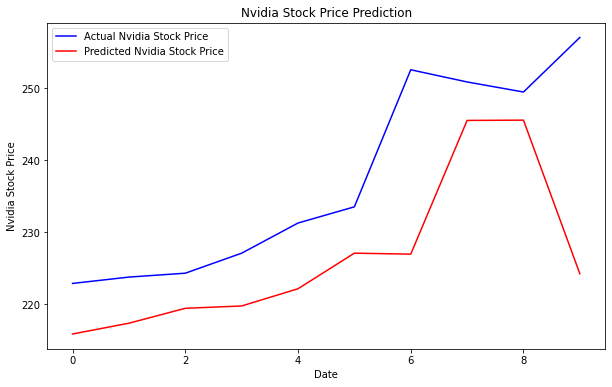

In [54]:
plt.figure(figsize=(10,6))  
plt.plot(test_stock_data_processed, color='blue', label='Actual Nvidia Stock Price')  
plt.plot(predicted_stock_price, color='red', label='Predicted Nvidia Stock Price')  
plt.title('Nvidia Stock Price Prediction')  
plt.xlabel('Date')  
plt.ylabel('Nvidia Stock Price')  
plt.legend()  
plt.show()  

# **Let's compare the "true high prices" vs "predicted prices" in a df**

In [ ]:
# Let's see the Model's predicted stock prices
predicted_stock_price

array([[220.19948],
       [223.95972]], dtype=float32)

In [ ]:
# Let's see what type of data the predicted stock price type is
type(predicted_stock_price)

numpy.ndarray

In [ ]:
# Let's reshape our predicted stock price and store it in another variable just in case it is shaped wrong
predicted_prices= predicted_stock_price.reshape(-1,1)

In [ ]:
# Let's see the predicted_prices now
predicted_prices

array([[220.19948],
       [223.95972]], dtype=float32)

In [ ]:
# Let's convert predicted_prices array above to a df and call it prediction and create a column titled "Predicted Price"
prediction = pd.DataFrame(predicted_prices, columns = ['Predicted Price'])


In [ ]:
# Let's see our prediction dataframe
prediction

,Predicted Price
0,216.095551
1,219.822800


In [ ]:
# Recall that our test_stock_data_processed is Palantir's closing prices between 2021-8-16 to 2021-08-19
# These are the true high prices
test_stock_data_processed

array([[222.91000366],
       [223.77999878]])

In [ ]:
# Let's store the test stock data array above as a df and name it closing_prices
true_high_closing_prices = pd.DataFrame(test_stock_data_processed, columns = ['Nvidia True Closing Price'])

In [ ]:
# Let's look at the df
true_high_closing_prices

,Nvidia True Closing Price
0,222.910004
1,223.779999


In [ ]:
# Let's Join the two DataFrames 
# we are joing our True prices and predicted prices so we can compare them
# see for more detail: https://www.geeksforgeeks.org/how-to-combine-two-dataframe-in-python-pandas/
result = pd.concat([true_high_closing_prices, prediction], axis=1, join='inner')


In [ ]:
# Let's see the combined df
result


,Nvidia True Closing Price,Predicted Price
0,222.910004,220.199478
1,223.779999,223.959717


In [ ]:
# Let's add another column called "Val_Diff" to our resulft df that takes the difference 
# between the first column called "Palantri True Closing Price" and the second column called "Predicted Price"
result['Val_Diff'] = result['Nvidia True Closing Price'] - result['Predicted Price']

In [ ]:
# Let's see how result df looks like now with the new column that calculates the difference
result

,Nvidia True Closing Price,Predicted Price,Val_Diff
0,222.910004,220.199478,2.710526
1,223.779999,223.959717,-0.179718


In [ ]:
# Let's store the results of this test to csv 
result.to_csv('/content/drive/MyDrive/Nvidia_Aug_to_Aug_test_result_Dense5_TrainingDateStart_Epoch500_Batch5.csv')


#**What If I want to predict prices for the next 5 days?**

See: https://thinkingneuron.com/predicting-stock-prices-using-deep-learning-lstm-model-in-python/

The model which we have built above uses the last 10 days prices and predicts the next day’s price because we have trained our model with many past examples of the same granularity as shown below

`last 35 days prices–> 11th day price`

Now if we want to predict the next 5 days or next 20 days prices, then we need to train the model with similar examples from the past like shown below

`last 35 days prices–> Next 5 days prices`

This is also known as **Multi-Step time series prediction**, where we predict multiple time steps ahead.

To achieve this, it will require small modifications in the data preparation step and in the LSTM model both.

However, keep in mind, the further you predict, the lesser accurate you might be, because stock prices are volatile and no one can know what is going to happen after 35 days! What kind of news will come? which might affect the prices of this stock!

Hence, it is recommended to predict for as less time steps as possible, for example next 2 days or next 5 days at max.



---

#**Data Preparation for Multi Step LSTM**

I am showing how to prepare the data for predicting next 5 days. The same code can be easily modified to predict next 10 days or 35 days as well.




In [32]:
# Considering the Full Data again which we extracted above
# Printing the last 10 values
FullData=test_stock_data[['Close']].values
print('Original Prices')
print(FullData[-13:])
 
print('###################')
 
# Printing last 10 values of the scaled data which we have created above for the last model
# Here I am changing the shape of the data to one dimensional array because
# for Multi step data preparation we need to X input in this fashion
X=sc.transform(FullData)
X=X.reshape(X.shape[0],)
print('Scaled Prices')
print(X[-10:])

Original Prices
[[222.22000122]
 [222.8999939 ]
 [221.02999878]
 [226.91999817]
 [227.25999451]
 [231.66000366]
 [247.16999817]
 [244.50999451]
 [247.40939331]]
###################
Scaled Prices
[0.96185674 0.96503167 0.95630054 0.98380133 0.9853888  1.00593273
 1.0783499  1.06593017 1.07946765]


# Predicting the Next 5 Days **High** price based on the high prices of the last 13 days


In [63]:
#=========================================================================
# Use this if test data is greater than 13 datapoints

#FullData = test_stock_data[['High']].values

#=========================================================================
# Use this if test data is less than 13 datapoints

# Since test_stock_data only has less than 13 datapoints (rows) in it, we don't
# have enough data to get the last 13 days worth of prices;
# therefore, we will have to use the all_stock_data which hold the 
# training dataset and the test dataset

# Again, since testing data is small, this is how we will actually do it
# use line immediately below if we have ran a test first and 
# variable all_stock_data had been created(=a concatenation of training and test data), 
#FullData = all_stock_data.values 

#===========================================================================
# Use this of we did not run a test at all

# Since we did not run a test at all, we don't have the variable all_stock_data.values, 
# use this line instead to get the high values of the stock_data which 
# only contains the training data
FullData=stock_data[['High']].values
#=====================================================================

# the rest is fine
Last13Days = FullData[-14:]
Last13Days

# Normalizing the data just like we did for training the model
# Reshaping the data to (-1,1) because its a single entry
Last13Days = Last13Days.reshape(-1, 1)

# Scaling the data on the same level on which model was trained
X_test = sc.transform(Last13Days)

# or we could have done it line so, 2 steps in 1
#Last13Days=sc.transform(Last13Days.reshape(-1,1))
  
NumberofSamples = 1

# Choosing TimeSteps as 13 because we have used the same for training
# notice that currently X_test.shape = (13, 1)
# 13 rows and 1 column
TimeSteps = X_test.shape[0] # =13
NumberofFeatures = X_test.shape[1] # =1

# Reshaping the data as 3D input / Changing the shape of the data to 3D
X_test = X_test.reshape(NumberofSamples, TimeSteps, NumberofFeatures) # now that we reshaped it, X_test.shape = (1, 13, 1)
 
# Generating the predictions for next 5 days
#Next5DaysUsingLast13 = model.predict(X_test) # use this when using the final model rather than the reconstructed one
Next5DaysUsingLast13 = reconstructed_model.predict(X_test) # use this when using the reconstructed model

# Generating the predicted prices in original scale
Next5DaysUsingLast13 = sc.inverse_transform(Next5DaysUsingLast13)

# Let's see the array of the predicted prices for the next 5 days
Next5DaysUsingLast13

array([[215.53554]], dtype=float32)

**TESTING TESTING**

In [ ]:
FullData = test_stock_data[['High']].values
Last13Days = FullData[-13:]
Last13Days

Last13Days = Last13Days.reshape(-1, 1)

X_test = sc.transform(Last13Days)

NumberofSamples = 1
TimeSteps = X_test.shape[0] # =13
NumberofFeatures = X_test.shape[1] # =1
X_test = X_test.reshape(NumberofSamples, TimeSteps, NumberofFeatures)



Next5DaysUsingLast13 = reconstructed_model.predict(X_test)
Next5DaysUsingLast13 = sc.inverse_transform(Next5DaysUsingLast13)
Next5DaysUsingLast13


array([[211.6737]], dtype=float32)

In [ ]:
# Making predictions on test data
Last10DaysPrices=array([1376.2, 1371.75,1387.15,1370.5 ,1344.95, 
                   1312.05, 1316.65, 1339.45, 1339.7 ,1340.85])
 
# Reshaping the data to (-1,1 )because its a single entry
Last10DaysPrices=Last10DaysPrices.reshape(-1, 1)
 
# Scaling the data on the same level on which model was trained
X_test=DataScaler.transform(Last10DaysPrices)
 
NumberofSamples=1
TimeSteps=X_test.shape[0]
NumberofFeatures=X_test.shape[1]
# Reshaping the data as 3D input
X_test=X_test.reshape(NumberofSamples,TimeSteps,NumberofFeatures)
 
# Generating the predictions for next 5 days
Next5DaysPrice = regressor.predict(X_test)
 
# Generating the prices in original scale
Next5DaysPrice = DataScaler.inverse_transform(Next5DaysPrice)
Next5DaysPrice

In [ ]:
Last13Days

array([[222.77000427],
       [223.21000671],
       [214.33000183],
       [214.25      ],
       [219.6000061 ],
       [225.3500061 ],
       [221.49000549],
       [217.99000549],
       [214.19000244],
       [210.16999817],
       [210.66000366],
       [208.58999634],
       [205.41999817],
       [206.47999573],
       [207.19999695],
       [213.22000122],
       [212.05999756]])

In [ ]:
# this demonstrates how test dataset does not have enough datapoints; 
# hence the need to use the all dataset
# Let's see the dates and prices for the last 13 days
get_all_high_prices = test_stock_data['High']
get_last_13 = get_all_high_prices[-4:]
print(get_last_13)

Date
2021-10-05    206.479996
2021-10-06    207.199997
2021-10-07    213.220001
2021-10-08    212.059998
Name: High, dtype: float64


In [ ]:
NumberofFeatures

1

In [ ]:
columns= ['Predicted Prices for Next 5 days using last 13']
predicted_prices = pd.DataFrame(np.reshape(Next5DaysUsingLast13, (5,len(Next5DaysUsingLast13))),columns=columns)

ValueError: ignored

In [ ]:
# Let's plot our predicted prices
predicted_prices

NameError: ignored

In [ ]:
# Let's convert our prediction to csv if needed
predicted_prices.to_csv('/content/drive/MyDrive/Palantir_Aug09_to_Aug13_predictions.csv')

# Let's get the real high prices for the next 5 days so we can compare them to our predicted prices

In [ ]:
# real stock prices from 5 days  

testing_start_date = '2021-08-14'
testing_end_date = '2021-08-21'

hum_stock_data= nvidia_stock_prices.history(start=testing_start_date, end=testing_end_date, auto_adjust=True)

In [ ]:
hum_stock_data

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2021-08-16,201.350006,202.869995,194.529999,199.500000,21087600,0,0
2021-08-17,196.850006,197.699997,192.669998,194.580002,20458500,0,0
2021-08-18,195.000000,196.339996,190.000000,190.399994,28591300,0,0
2021-08-19,194.940002,204.949997,187.619995,197.979996,76655500,0,0
2021-08-20,199.910004,208.650604,199.330002,208.160004,67574131,0,0


In [ ]:
real_high = hum_stock_data['High']

In [ ]:
print(real_high)

Date
2021-08-16    202.869995
2021-08-17    197.699997
2021-08-18    196.339996
2021-08-19    204.949997
2021-08-20    208.650604
Name: High, dtype: float64


In [ ]:
# Let's get the real high prices into an array of values
real_prices_of_future5days_using_last_13= real_high.values
real_prices_of_future5days_using_last_13

array([202.86999512, 197.69999695, 196.33999634, 204.94999695,
       208.65060425])

In [ ]:
columns=['Actual prices for Next 5 Days using last 13']
actual_prices = pd.DataFrame(real_prices_of_future5days_using_last_13, columns=columns)
actual_prices

,Actual prices for Next 5 Days using last 13
0,202.869995
1,197.699997
2,196.339996
3,204.949997
4,208.650604


In [ ]:
# Let's concatenate our actual prices and our predicted prices for the future 5 days
results = pd.concat([actual_prices, predicted_prices], axis=1, join='inner')
results

,Actual prices for Next 5 Days using last 13,Predicted Prices for Next 5 days using last 13
0,202.869995,202.218323
1,197.699997,202.218323
2,196.339996,202.218338
3,204.949997,202.218338
4,208.650604,202.218323


In [ ]:
df = pd.DataFrame(results)

# Let's include another column showing the difference between true price and predicted price
df['Val_Diff'] = df['Actual prices for Next 5 Days using last 13'] - df['Predicted Prices for Next 5 days using last 13']
df

,Actual prices for Next 5 Days using last 13,Predicted Prices for Next 5 days using last 13,Val_Diff
0,202.869995,202.218323,0.651672
1,197.699997,202.218323,-4.518326
2,196.339996,202.218338,-5.878342
3,204.949997,202.218338,2.731659
4,208.650604,202.218323,6.432281


In [ ]:
# Let's convert our prediction to csv
df.to_csv('/content/drive/MyDrive/Palantir_Aug09_to_Aug13_predictions_last13_starttraining20201024_to_20210515.csv')

# Predicting the Next 5 Days **High** price based on the high prices of the last 10 days
* We get to see that using last 10 days results in a bad prediction

In [ ]:
#===============================================================
# We won't use the test dataset (code below) to get our last 13 real prices
# because it only has 4 datapoints
#FullData=test_stock_data[['High']].values

# Let's get the high prices of the last 10 days from all the data
#Last10Days=FullData[-10:]
#Last10Days
 
# Reshaping the data to (-1,1 )because its a single entry
#Last10Days = Last10Days.reshape(-1, 1)
#================================================================

# We will need to use the all_stock_data dataset
# because it contains the last concatenation of the original
# training data from '2020-10-24' to '2021-08-15' and 
# the test data from '2021-08-16' to '2021-08-19
# This represents ALL of our current data

FullData = all_stock_data.values
Last10Days = FullData[-10:]

# Reshaping the data to (-1,1) because its a single entry
Last10Days = Last10Days.reshape(-1, 1)

# Scaling the data on the same level on which model was trained
X_test=sc.transform(Last10Days)
 
NumberofSamples=1
TimeSteps=X_test.shape[0]
NumberofFeatures=X_test.shape[1]
# Reshaping the data as 3D input
X_test=X_test.reshape(NumberofSamples,TimeSteps,NumberofFeatures)
 
# Generating the predictions for next 5 days
Next5DaysUsingLast10 = model.predict(X_test)
 
# Generating the prices in original scale
Next5DaysUsingLast10 = sc.inverse_transform(Next5DaysUsingLast10)
Next5DaysUsingLast10

array([[205.22101, 205.22101, 205.221  , 205.221  , 205.22101]],
      dtype=float32)

In [ ]:
columns= ['Predicted Prices for Next 5 days using last 10']
predicted_prices_using_last10 = pd.DataFrame(np.reshape(Next5DaysUsingLast10, (5,len(Next5DaysUsingLast10))),columns=columns)

In [ ]:
predicted_prices_using_last10

,Predicted Prices for Next 5 days using last 10
0,205.221008
1,205.221008
2,205.220993
3,205.220993
4,205.221008


In [ ]:
print(real_high)

Date
2021-08-09    205.080002
2021-08-10    204.300003
2021-08-11    200.490005
2021-08-12    200.289993
2021-08-13    202.139999
Name: High, dtype: float64


In [ ]:
# Let's get the real high prices into an array of values
real_prices_of_future5days_using_last_10= real_high.values
real_prices_of_future5days_using_last_10

array([205.08000183, 204.30000305, 200.49000549, 200.28999329,
       202.13999939])

In [ ]:
columns=['Actual prices for Next 5 Days']
actual_prices = pd.DataFrame(real_prices_of_future5days_using_last_10, columns=columns)
actual_prices

,Actual prices for Next 5 Days
0,205.080002
1,204.300003
2,200.490005
3,200.289993
4,202.139999


In [ ]:
results = pd.concat([actual_prices, predicted_prices_using_last10], axis=1, join='inner')
results

,Actual prices for Next 5 Days,Predicted Prices for Next 5 days using last 10
0,205.080002,205.221008
1,204.300003,205.221008
2,200.490005,205.220993
3,200.289993,205.220993
4,202.139999,205.221008


In [ ]:
df = pd.DataFrame(results)

# Let's include another column showing the difference between true price and predicted price
df['Val_Diff'] = df['Actual prices for Next 5 Days'] - df['Predicted Prices for Next 5 days using last 10']
df

,Actual prices for Next 5 Days,Predicted Prices for Next 5 days using last 10,Val_Diff
0,205.080002,205.221008,-0.141006
1,204.300003,205.221008,-0.921005
2,200.490005,205.220993,-4.730988
3,200.289993,205.220993,-4.931000
4,202.139999,205.221008,-3.081009


In [ ]:
# Let's convert our prediction to csv 
# this prediction is based on using the last 10 real prices
#df.to_csv('/content/drive/MyDrive/Using_last10_Aug09_to_Aug14_predictions.csv')